## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


In [18]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *
from lib.real_time_video import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=1000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)


# frames = np.random.randint(0, 256, size=(1, height, width), dtype=np.uint8)
frames = np.empty((0, height, width), dtype=np.uint8) 

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (1, height, width))
    frames = np.append(frames,gray_frame, axis=0)  # Append the gray_frame as a new row to the frames array
    

event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print(frames.shape)


(114, 720, 1280)


In [3]:
# Compact the frames

max_buffer = 10
# blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
frames_buffer = np.empty((0, height, width), dtype=np.uint8) 


st = time.perf_counter()
for i, _ in enumerate(frames):
    frames_buffer = np.append(frames_buffer, np.reshape(frames[i], (1, height, width)), axis=0)
    if frames_buffer.shape[0] == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = np.empty((0, height, width), dtype=np.uint8) 
print((time.perf_counter() - st)/len(frames))


print(len(copact_frames))

/home/ignaciozm/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


0.018495652307026097
11


In [4]:
# Watch the compacted frames (OPTIONAL)

# for frame in copact_frames:
#     dst = cv2.fastNlMeansDenoising(frame)
#     cv2.imshow('press q to quit', dst)  
#     key = cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
    
#     if key == ord('q'):
#             cv2.destroyAllWindows()
#             break
    
#     cv2.destroyAllWindows()

In [5]:
# Check different filters (OPTIONAL)

# frame = copact_frames[5]
# frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
# plot_image(np.array(frame))

# # plot_image(np.array(cv2.fastNlMeansDenoising(copact_frames[5])))
# frame = cv2.blur(frame,(3,3))
# print('max value: ', np.max(frame)), print('min value: ', np.min(frame))
# plot_image(np.array(frame))

# #Transform image to 0 255 range
# frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
# plot_image(np.array(frame))

# frame = cv2.threshold(frame, 100, 1, cv2.THRESH_TOZERO)[1]
# plot_image(np.array(frame))


Original clusters:  26 Fitered clusters:  26


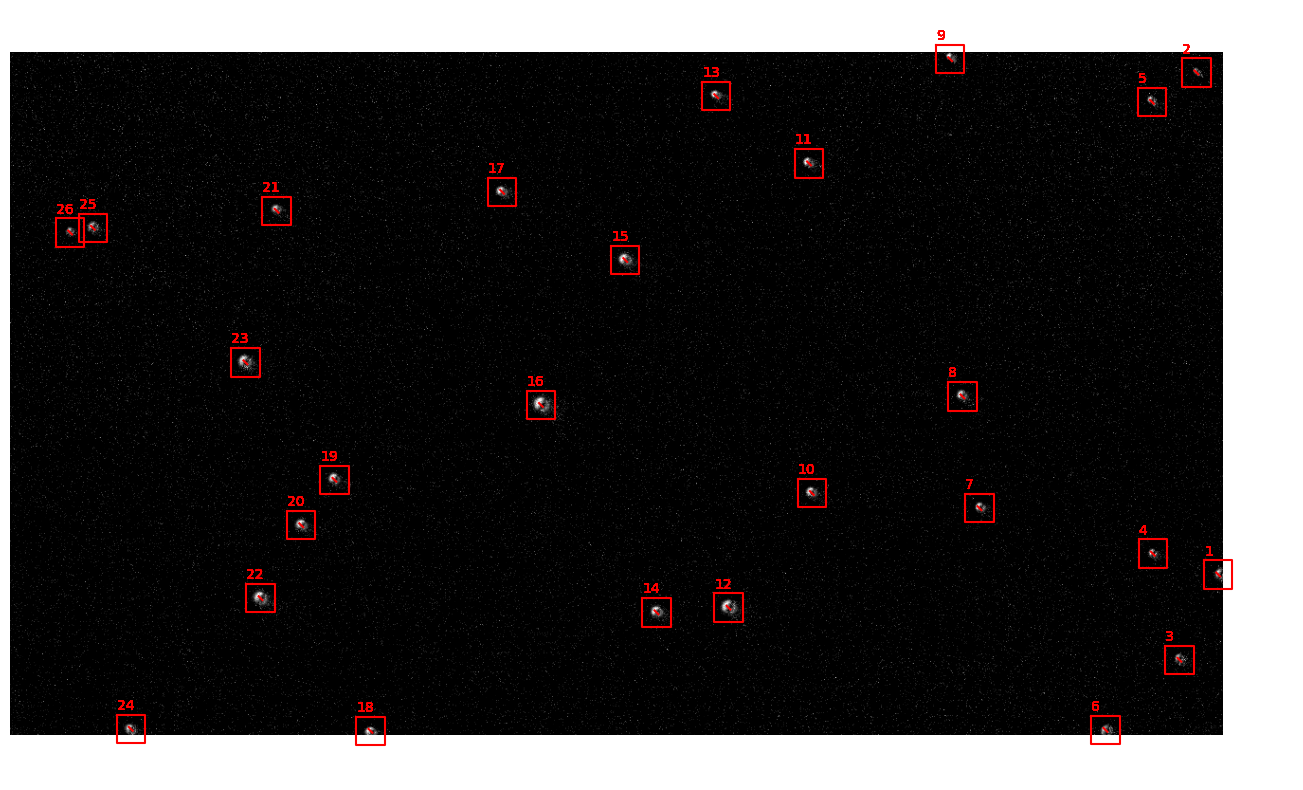

In [4]:
from lib.utils import *
from lib.event_processing import *

treshold = 0.3 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 15

for index, frame in  enumerate(copact_frames) :

    frame = cv2.blur(frame,(3,3))
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

    max_val = np.max(frame)
    frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
    filtered_frames.append(frame_thr)
    
    clusters =  max_value_cluster(frame_thr, pixel_range, 30)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
    clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

    # print('Frame: ', index ,' Original clusters: ', len(clusters_index))

# FOR NOISY IMAGES delete the clusters with a mass lower than a treshold
mass_treshold = 0.2
treshold_val = mass_treshold*np.max([cluster_mass[1] for cluster_mass in  clusters_list[9]])
clusters_list_filtered = [cluster for cluster in clusters_list[9] if cluster[1] > treshold_val ]

print('Original clusters: ', len(clusters_list[9]),'Fitered clusters: ',  len(clusters_list_filtered))

#JUST TO CHECK SOM WITHOUT FALSE STARS
# clusters_list_filtered.pop(2) # Remove the cluster 3 of the frame 12
# clusters_list_filtered.pop(5) # Remove the cluster 7(-1) of the frame 12

plot_cluster(copact_frames[9], [x[0] for x in clusters_list_filtered], pixel_range, [18.5,10])



## GET STAR FEATURES AND STAR CENTROID 

Image center:  [360. 640.]
Order by distance to the center of the image
Cluster 1 [array([371, 560]), 32143]: distance to center: 80.75270893288967
Cluster 2 [array([218, 649]), 22597]: distance to center: 142.28492541376264
Cluster 3 [array([464, 846]), 16393]: distance to center: 230.7639486574972
Cluster 4 [array([590, 682]), 19317]: distance to center: 233.80333616097099
Cluster 5 [array([146, 519]), 16727]: distance to center: 245.83937845674765
Cluster 6 [array([585, 758]), 26818]: distance to center: 254.0649523251879
Cluster 7 [array([450, 342]), 17027]: distance to center: 311.2940731848263
Cluster 8 [array([116, 843]), 14775]: distance to center: 317.40352865083275
Cluster 9 [array([ 45, 745]), 14379]: distance to center: 332.03915431767985
Cluster 10 [array([498, 307]), 18737]: distance to center: 360.46220328905497
Cluster 11 [array([ 362, 1005]), 15862]: distance to center: 365.0054794109261
Cluster 12 [array([326, 248]), 23000]: distance to center: 393.47172706561776
Clus

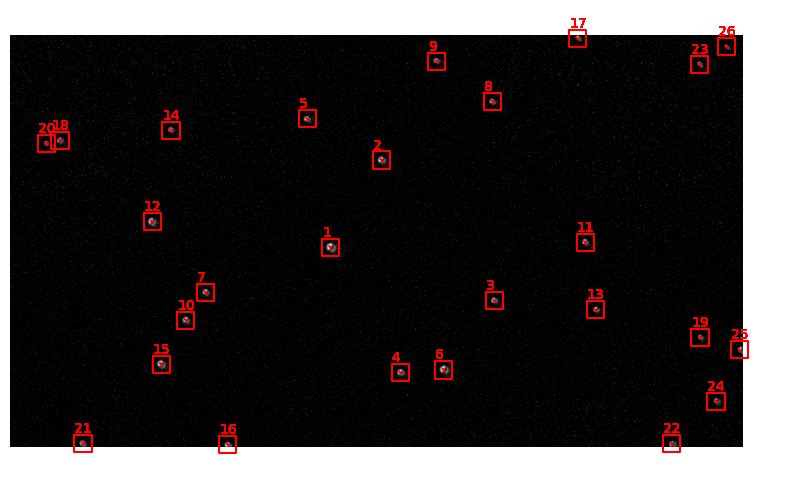

In [7]:
# Pop last value of each cluster (Previous cluster position)
# if len(clusters[0]) == 3:
    # [cluster.pop() for cluster in clusters]


clusters = clusters_list_filtered
# Get the clusters that are closest to the center of the image
clusters_sort, clusters_dist= order_by_center_dist([cluster for cluster in clusters ], copact_frames[9].shape)

print('Image center: ', np.array(frames[11].shape)/2)
print('Order by distance to the center of the image')
for i in range(len(clusters_sort)):
    print(f"Cluster {i+1} {clusters_sort[i][:2]}: distance to center: {clusters_dist[i]}")
# Plot the clusters on the image.

plot_cluster(copact_frames[9], [x[0] for x in clusters_sort], pixel_range)


# Speficic stars features check

Features 1 len:  8 , Features 2 len:  10
Main star:  [0.35621262 0.53767943]
Neighbours stars: 
   Star 1: [2.99314618 8.91078841] 
   Star 2: [2.00458414 7.12588472] 
   Star 3: [6.17851277 4.6956697 ] 
   Star 4: [8.10071674 9.36387935] 
[0.8879957  0.         1.14426319 0.70709902 1.158019   2.44531639
 1.23604334 4.17670794]
[2.43025381 3.14012683 3.18362026 3.44196777 2.04037646 5.28334988
 5.12762795 4.82986803 6.49395508 5.04847001]


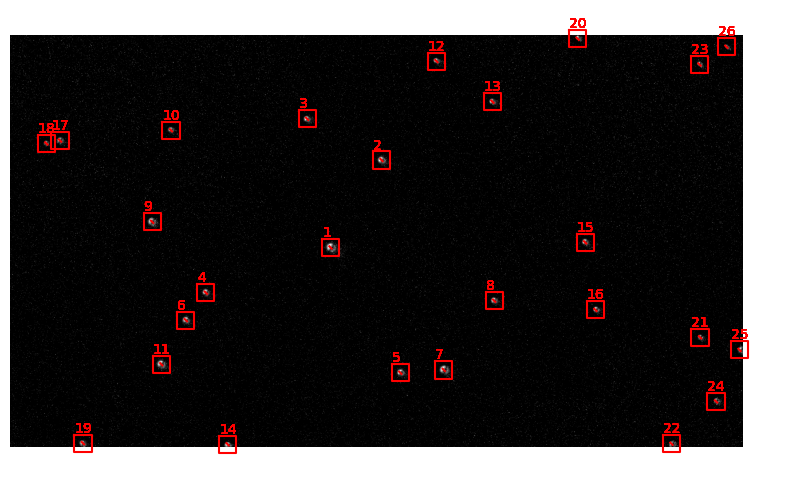

In [35]:
# Get the features of the selected main star 
from lib.event_processing import *

main_star = clusters_sort[0]
stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)


# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV
ref_pixel_to_deg = 0.0009601418439716312

reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees

num_of_neirbours = 4
stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
        stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

print('Features 1 len: ',len(stars_features_1), ', Features 2 len: ', len(stars_features_2))
print('Main star: ', clusters_sort[0][0] * ref_pixel_to_deg * reference_FOV)
print('Neighbours stars: ')
for i in range(1,5): 
    print(f"   Star {i}: {stars_sorted_by_main[i][0] * ref_pixel_to_deg * recording_FOV} ")
print(stars_features_1)
print(stars_features_2)

plot_cluster(copact_frames[9], [x[0] for x in stars_sorted_by_main], pixel_range)

[array([5.16249067, 7.81238614]), array([3.06179633, 9.03435867]), array([2.07323428, 7.23572495]), array([6.24716291, 4.81923996]), array([8.15563685, 9.4874496 ])]
[[41.234935, 10.114216], [41.239628, 12.445956], [39.157316, 12.44784], [39.146259, 7.730073], [44.928738, 8.907399]]
features 1  (array([0.8879957 , 0.        , 1.14505597, 0.71139724, 1.158019  ,
       2.44531639, 1.23255438, 4.17865601]), array([2.43025381, 3.14261724, 3.18362026, 3.42997984, 2.05239815,
       5.28334988, 5.11395177, 4.82297417, 6.48582184, 5.04325828]))
features 2  (array([0.8466168 , 0.        , 1.1392641 , 0.72944118, 1.15362237,
       2.42416965, 1.35736684, 4.3986203 ]), array([2.33174472, 3.12446822, 3.16965381, 3.88594749, 2.08231285,
       5.15962656, 5.11184098, 4.71777996, 6.77082228, 5.90111514]))


/tmp/ipykernel_5483/1265332478.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos = np.multiply(np.array(stars_sorted_by_main)[0:5, 0] ,ref_pixel_to_deg * recording_FOV).tolist()


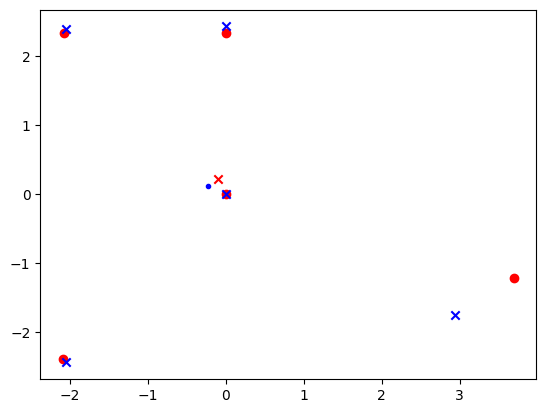

In [11]:
from lib.event_processing import *
# pos = [[0.36101333, 0.54632071],
#         [0.21411163,0.63177333],
#         [0.14498142, 0.50599475],
#         [0.43686454 ,0.33700979],
#         [0.57032426, 0.66345801] ] 

pos = np.multiply(np.array(stars_sorted_by_main)[0:5, 0] ,ref_pixel_to_deg * recording_FOV).tolist()

pos_2 = [[41.234935 , 10.114216],
        [41.239628 , 12.445956],
        [39.157316 , 12.447840],
        [39.146259 , 7.730073],
        [44.928738 , 8.907399] ]

print(pos)
print(pos_2)

figure, ax = plt.subplots()
#Rescale the position to the main star to the center 

pos = np.array(pos) - pos[0]
pos_2= np.array(pos_2) - pos_2[0]

# fac = np.linalg.norm(pos_2[1]  ) / np.linalg.norm(pos[1] )
# pos = np.array(pos) * fac


#ROtate 
alpha = -60
alpha = alpha*np.pi/180
R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]])
pos_rot = np.dot(R, pos.T).T

center = np.mean(pos_rot, axis=0)
center_2 = np.mean(pos_2, axis=0)

ax.scatter([x[0] for x in pos_2], [x[1] for x in pos_2], color='r', label='From dataset')
ax.scatter([x[0] for x in pos_rot], [x[1] for x in pos_rot], color='b', label='From recording', marker='x')
ax.scatter(center[0], center[1], color='b', label='Center', marker='.')
ax.scatter(center_2[0], center_2[1], color='r', label='Center', marker='x')


# Get features
print( 'features 1 ', get_star_features(np.array(pos), 1, 1, 1) )
print( 'features 2 ', get_star_features(np.array(pos_2), 1, 1, 1) )

In [12]:
import numpy as np
def test_get_features_2(): 
    '''
    Test the get features function
    
    '''
    #Rotation matrix
    # alpha = 0.1

    # R = np.array([[np.cos(alpha), -np.sin(alpha)],
    #                 [np.sin(alpha), np.cos(alpha)]])

    trans = 45
    test_stars =[ [45.569912 , 4.089921],
                [45.593785 , 4.352873],
                [48.109873 , 6.660885],
                [49.839787 , 3.369980],
                [50.278217 , 3.675680]] 
    test_stars * trans
    test_stars = np.array(test_stars)

    test_sol_1 = [-1.33168062,  0.          ,1.28482521,  5.59439346,  1.46560083,  4.63589112,1.55318345,  4.71517452]
    test_sol_2 = [0.2640331480554887, 3.6140362126900363, 4.330144122389013, 4.726492802567647, 3.4143256508227946, 4.358280776498913, 4.733127431736677, 3.717883378629331, 3.6896019300520404, 0.5344845768068048]
    features_1, features_2 = get_star_features(test_stars,1,1,1)


    print('Features 1 len: ',len(features_1), ', Features 2 len: ', len(features_2))
    print('Main star: ', test_stars[0]) 
    print('Features 1: ', features_1)
    print('Features 2: ', features_2)
    print('Test sol 1: ', test_sol_1)

    errors = 0
    for alpha in range(0, 1, 100):
        alpha = alpha*np.pi/180
        R = np.array([[np.cos(alpha), -np.sin(alpha)],
                    [np.sin(alpha), np.cos(alpha)]])
        test_stars_rot = np.dot(R, test_stars.T).T
        features_1, features_2 = get_star_features(test_stars_rot,1,1,1)

        features_1[::2] += np.log(trans)
        error1 = test_sol_1 - features_1
        if np.max(error1) > 0.001:
            print('alpha: ', alpha*180/np.pi)
            print('Features 1: ', features_1)
            print('Features 1 sol: ', test_sol_1)
            print('Error 1: ', error1)
            errors +=1 
    if errors == 0:
        print('Test 1 passed: rotational invariant')

    # print('Test error 1:', np.array(test_sol_1) - np.array(features_1))
    # print('Test error 2:', np.array(test_sol_2) - np.array(features_2))

test_get_features_2()

Features 1 len:  8 , Features 2 len:  10
Main star:  [45.569912  4.089921]
Features 1:  [-1.3316794   0.          1.28482521  5.59439331  1.46560081  4.6358909
  1.55318339  4.71517424]
Features 2:  [0.26403347 3.61403622 4.33014406 4.72649252 3.41432544 4.35828081
 4.73312725 3.71788356 3.68960223 0.5344842 ]
Test sol 1:  [-1.33168062, 0.0, 1.28482521, 5.59439346, 1.46560083, 4.63589112, 1.55318345, 4.71517452]
Test 1 passed: rotational invariant


# Load data


In [8]:
import pickle

mesh_size = 80
catalog_filter = 6 # Tycho catalog filter for brighness 

name = 'n80_tycho6'
name = 'n78_88_tycho6'

if name == None:
    name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open('../data/SOM_parameters/'+name+'/index_'+ name + '.p', 'rb') as infile:
    indices = pickle.load(infile)

# Predict stars

In [22]:
np.array([star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]])

array([[371, 560],
       [218, 649],
       [146, 519],
       [450, 342],
       [590, 682]])

In [15]:
clusters_sort[1]

[array([218, 649]), 22597]

In [ ]:
[star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]]

In [23]:
get_star_features_2(
    np.array([star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]]),
    feature_type_1,
    ref_pixel_to_deg, reference_FOV, recording_FOV
)

array([], dtype=float64)

In [27]:
#Get the image postion
from lib.event_processing import *
import time


ref_pixel_to_deg = 0.0009601418439716312
reference_FOV = 1 #In degrees
recording_FOV = 14.3 #In degrees
num_of_neirbours = 4 

stars_data_df = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data_df[['HIP','RA(ICRS)', 'DE(ICRS)']].values

feature_type_1 = 'permutation_angle_dist'
feature_type_2 = 'permutation'


features_vec_1 = []
features_vec_2 = []
predcited_stars = []
indices_image = []

time_start = time.time()
for main_star in clusters_sort:

    #Order by distance to the main star at the loop
    stars_sorted_by_main, index_sort = order_by_main_dist(main_star, clusters_sort, True)
    indices_image.append(index_sort[0:num_of_neirbours+1])
        
    stars_features_1 = get_star_features_2(
       [star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]],
        feature_type_1,
        ref_pixel_to_deg, reference_FOV, recording_FOV
    )
    stars_features_2 = get_star_features_2(
        [star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]],
        feature_type_2,
        ref_pixel_to_deg, reference_FOV, recording_FOV
    )

    # stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
    #         stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)

    features_vec_1.append(stars_features_1)
    features_vec_2.append(stars_features_2)

    # Get prediction index
    predicted_star_ids_1 = predict_star_id(stars_features_1, norm_param[0:2], star_dict_1, som1)
    predicted_star_ids_2 = predict_star_id(stars_features_2, norm_param[2:4], star_dict_2, som2)
    # Get HIP of index
    hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
    hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]


    if predicted_star_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = predicted_star_ids_2
    elif predicted_star_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = predicted_star_ids_1
    else:
        star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(predicted_star_ids_1) == 1 and len(predicted_star_ids_2) != 1:
            star_guess = (predicted_star_ids_1)
        elif len(predicted_star_ids_2) == 1 and len(predicted_star_ids_1) != 1:
            star_guess = (predicted_star_ids_2)
        elif len(predicted_star_ids_2) == 1 and len(predicted_star_ids_1) == 1:
            act_som1 = som1.activate( (stars_features_1 - norm_param[0])/(norm_param[1]-norm_param[0])  )
            act_som2 = som2.activate( (stars_features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = predicted_star_ids_1
            else:
                star_guess = predicted_star_ids_2

    # Get the intersection of the two predictions if there is only one star in common
    if len(star_guess) == 1:
                star_guess_index = star_guess[0]
                star_guess_id = stars_data[star_guess_index].astype(int)[0]

    # if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2 and len(
    #     list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) > 0:
    #     star_guess_index = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
    #     star_guess_id = list(set(hip_ids_predicted_1).intersection(hip_ids_predicted_2))[0]

    else:
        star_guess_index = None
        star_guess_id = None
    predcited_stars.append([hip_ids_predicted_1, hip_ids_predicted_2, star_guess_index, star_guess_id])


time_end = time.time()
print('Time to get predictions: ', time_end - time_start, 'average time: ', (time_end - time_start)/len(clusters_sort))
for i in range(len(predcited_stars)):
    print('Main star: ', clusters_sort[i][:2])
    print(' Predicted star ids 1: ', predcited_stars[i][0])
    print(' Predicted star ids 2: ', predcited_stars[i][1])
    print(' Predicted star id: ', predcited_stars[i][3], 'Index: ', predcited_stars[i][2])
    print('Neighbours stars indices: ', indices_image[i])
    # print(stars_data[predcited_stars[i][2]] if predcited_stars[i][2] is not None else 'No star found')


print('Ids vector: ', [x[3] for x in predcited_stars])

Time to get predictions:  0.07172226905822754 average time:  0.0027585488099318286
Main star:  [array([371, 560]), 32143]
 Predicted star ids 1:  [107975]
 Predicted star ids 2:  [12828, 102831]
 Predicted star id:  107975 Index:  1133
Neighbours stars indices:  [0, 1, 4, 6, 3]
Main star:  [array([218, 649]), 22597]
 Predicted star ids 1:  [47205]
 Predicted star ids 2:  [12832]
 Predicted star id:  12832 Index:  15
Neighbours stars indices:  [1, 4, 0, 8, 7]
Main star:  [array([464, 846]), 16393]
 Predicted star ids 1:  [25608]
 Predicted star ids 2:  [14135]
 Predicted star id:  25608 Index:  2979
Neighbours stars indices:  [2, 5, 12, 10, 3]
Main star:  [array([590, 682]), 19317]
 Predicted star ids 1:  [103401]
 Predicted star ids 2:  [14135]
 Predicted star id:  103401 Index:  4557
Neighbours stars indices:  [3, 5, 2, 0, 15]
Main star:  [array([146, 519]), 16727]
 Predicted star ids 1:  [47310]
 Predicted star ids 2:  [12153]
 Predicted star id:  12153 Index:  16
Neighbours stars in

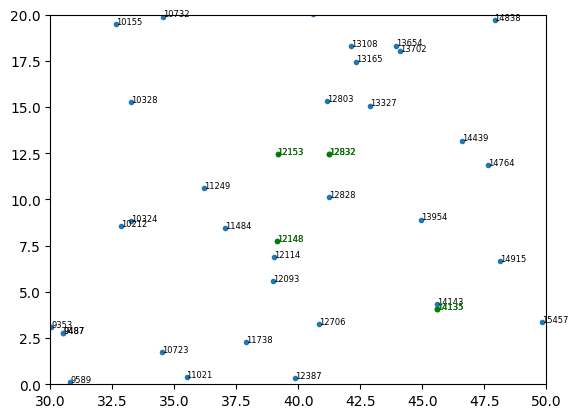

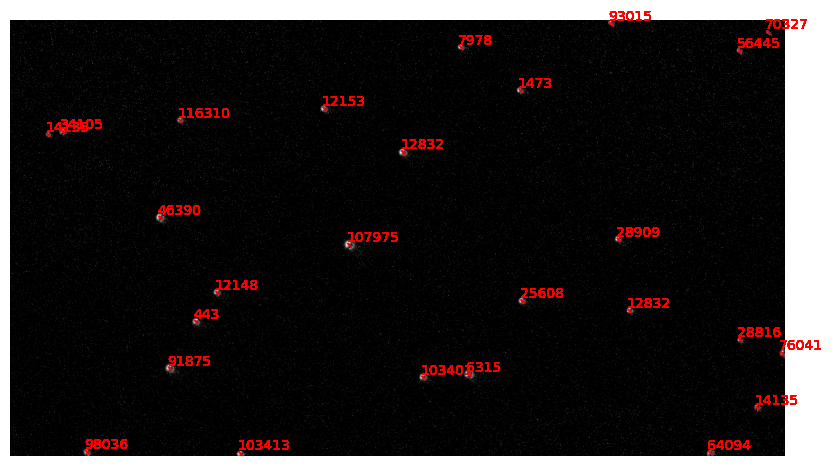

In [28]:
from lib.plot_utils import *
plt.figure()

x_range = [30, 50]
y_range = [0, 20]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

# plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
# #Plot the identification names of the set of stars
for i in range(len(stars_data)):
    if stars_data[i,1] < x_range[1] and stars_data[i,1] > x_range[0] and stars_data[i,2] < y_range[1] and stars_data[i,2] > y_range[0]:
        plt.text(stars_data[i,1], stars_data[i,2], str(int(stars_data[i,0])) , fontsize=6)

x_range = [30, 50]
y_range = [0, 20]

not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_data[not_none]
#Check that the stars are in range 
# stars_subdata = [x.tolist() for x in stars_subdata if np.round(x[1]) in range(x_range[0], x_range[1]) and np.round(x[2]) in range(y_range[0], y_range[1])]

plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
#Plot the identification names of the sub set of stars
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show()  

ids = []
for x in predcited_stars:
    ids.append(int(stars_data[x[2]][0]) if x[2] is not None else None)

plot_cluster_with_id(copact_frames[9], np.array(clusters_sort, dtype=object)[:,0], ids)

In [29]:
import time
time_start = time.time()
indices_neigh_gt  = np.full((len(predcited_stars),num_of_neirbours+1 ), None)
for i, predicted_star in enumerate(predcited_stars):
    if predicted_star[2] is not None:
       indices_neigh_gt[i]  = indices[predicted_star[2]]


indices_neigh_image = np.array([np.array(predcited_stars, dtype=object)[:,2][index] for index in indices_image], dtype=object)

print('Time: ', time.time()- time_start)

# time_start = time.time()
# indices_ids = [indices[predicted_star[2]] if predicted_star[2] is not None else None for predicted_star in predcited_stars]
# print('Time: ', time.time()- time_start)

print(len(indices_neigh_gt), len(indices_neigh_image))
for i in range(len(indices_neigh_gt)):
    if indices_neigh_gt[i][0] is not None:
      print('gt: ', indices_neigh_gt[i], 'image: ', indices_neigh_image[i])

Time:  0.0014264583587646484
26 26
gt:  [1133 1134 1060 1057 1130] image:  [1133 15 16 11 4557]
gt:  [15 16 12 18 19] image:  [15 16 1133 3021 268]
gt:  [2979 2976 2980 2981 2974] image:  [2979 222 15 3235 4557]
gt:  [4557 4558 4559 4553 4556] image:  [4557 222 2979 1133 1272]
gt:  [16 15 12 14 18] image:  [16 15 1133 1744 3021]
gt:  [222 217 223 225 221] image:  [222 4557 2979 15 1133]
gt:  [11 10 9 13 12] image:  [11 1537 4461 3709 1133]
gt:  [268 269 270 1739 271] image:  [268 3021 4282 15 3235]
gt:  [3021 3022 3020 3019 3024] image:  [3021 268 15 16 4282]
gt:  [1537 1535 1536 1540 1529] image:  [1537 11 4461 3709 1272]
gt:  [3235 3434 3234 3437 2901] image:  [3235 15 2979 1854 268]
gt:  [3709 3710 3714 3711 2424] image:  [3709 11 1744 1537 3442]
gt:  [15 16 12 18 19] image:  [15 3235 2979 1854 862]
gt:  [1744 1745 1743 1143 1741] image:  [1744 3709 3442 0 16]
gt:  [4461 4460 4459 4455 4464] image:  [4461 1537 11 1272 2688]
gt:  [1272 1352 1354 1353 1274] image:  [1272 4461 1537 268

In [31]:
time_start = time.time()
confirmed_stars_ids, _= check_star_id_by_neight( np.array(indices_neigh_gt, dtype=object),
                                               np.array(indices_neigh_image, dtype=object),
                                               np.array(indices_image, dtype=object),
                                               True)
time_end = time.time()

predict_star_ids = [x[3] for x in predcited_stars]

# # Create a vector of size 10 with all None values
# confirmed_stars = np.array([None]*len(predcited_stars))
# confirmed_stars[confirmed_stars_index] = np.array(predict_star_ids)[confirmed_stars_index]

print('Confirmed stars IDs', confirmed_stars_ids,'time', time_end - time_start)
print('Predicted ids: ', predict_star_ids)
# print('Confirmed stars: ', confirmed_stars)



Confirmed stars IDs [12 15 None None 16 None None 19 18 None None None None 14 None None None
 None None None None None None None None None] time 0.0007672309875488281
Predicted ids:  [107975, 12832, 25608, 103401, 12153, 6315, 12148, 1473, 7978, 443, 28909, 46390, 12832, 116310, 91875, 103413, 93015, 34105, 28816, 14135, 98036, 64094, 56445, 14135, 76041, 70327]


In [109]:
confirmed_stars_ids[confirmed_indices]

array([12, 15, 16, 19, 18, 14], dtype=object)

In [114]:

stars_data[confirmed_stars_ids[confirmed_indices].tolist()][:,0]

array([12828., 12832., 12153., 13327., 12803., 11249.])

Image center:  [360. 640.]
Star:  12828.0 position:  [1.28280000e+04 4.12349347e+01 1.01142161e+01] image position:  [371 560]
Star:  12832.0 position:  [1.28320000e+04 4.12396281e+01 1.24459558e+01] image position:  [218 649]
Star:  12153.0 position:  [12153.            39.15731611    12.44783972] image position:  [146 519]
Star:  13327.0 position:  [13327.            42.87320222    15.08212333] image position:  [116 843]
Star:  12803.0 position:  [12803.            41.13737917    15.31189667] image position:  [ 45 745]
Star:  11249.0 position:  [1.12490000e+04 3.62043561e+01 1.06105967e+01] image position:  [166 281]
 Center:  [41.99623494 10.77660734]


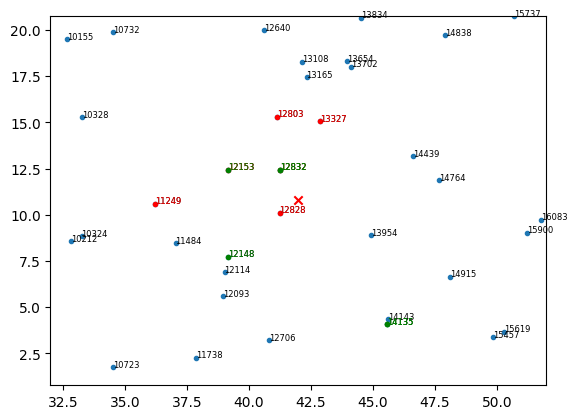

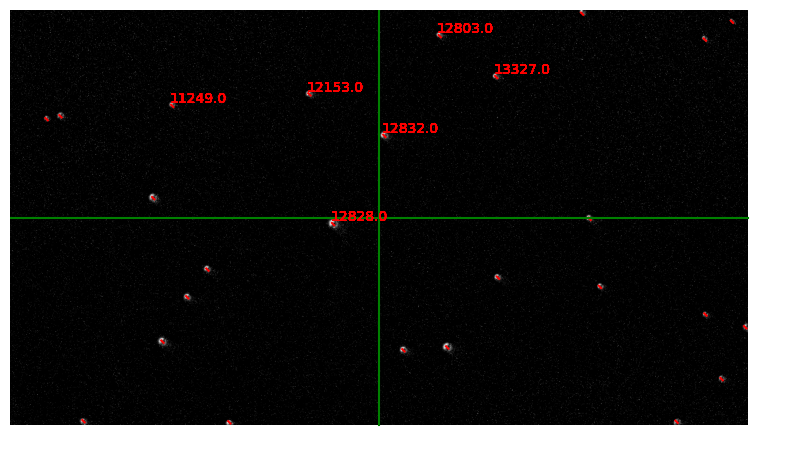

In [117]:
img_center = np.array(copact_frames[9].shape)/2

print('Image center: ', img_center)

confirmed_indices = [i for i in range(len(confirmed_stars_ids)) if confirmed_stars_ids[i] is not None]

distances = []
stars_position_tuple = []
for confirmed_index in confirmed_indices:
    dist_to_center = np.linalg.norm(img_center - clusters_sort[confirmed_index][0]) * ref_pixel_to_deg * recording_FOV / reference_FOV
    center_position = stars_data[confirmed_stars_ids[confirmed_index]][1:3] - dist_to_center* ref_pixel_to_deg * recording_FOV / reference_FOV
    print('Star: ', stars_data[confirmed_stars_ids[confirmed_index]][0], 'position: ', stars_data[confirmed_stars_ids[confirmed_index]]
          ,'image position: ', clusters_sort[confirmed_index][0])
    stars_position_tuple.append((stars_data[confirmed_stars_ids[confirmed_index]][1:3], clusters_sort[confirmed_index][0], stars_data[confirmed_stars_ids[confirmed_index]][0]))
    distances.append(dist_to_center)

x_c_solution, y_c_solution = solve_point_c(stars_data[confirmed_stars_ids[confirmed_indices].tolist()][:,1:3], distances)
center_solution = np.array([x_c_solution, y_c_solution])
print(' Center: ', center_solution)


from lib.plot_utils import *
plt.figure()

visual_range = 10 
x_range = [x_c_solution -visual_range, x_c_solution +visual_range]
y_range = [y_c_solution -visual_range, y_c_solution +visual_range]

#Plot the identification names of the set of stars in the range of the image
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

# plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
# #Plot the identification names of the set of stars
for i in range(len(stars_data)):
    if stars_data[i,1] < x_range[1] and stars_data[i,1] > x_range[0] and stars_data[i,2] < y_range[1] and stars_data[i,2] > y_range[0]:
        plt.text(stars_data[i,1], stars_data[i,2], str(int(stars_data[i,0])) , fontsize=6)

# plot the sub set of stars that were confirmed 
stars_subdata = stars_data[[x for x in confirmed_stars_ids if x is not None]]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.r')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'r')

#Plot the identification names of the sub set of stars fistly identified
not_none = [x[2] for x in predcited_stars if x[2] is not None]
stars_subdata = stars_data[not_none]
plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
for i in range(len(stars_subdata)):
    if stars_subdata[i,1] < x_range[1] and stars_subdata[i,1] > x_range[0] and stars_subdata[i,2] < y_range[1] and stars_subdata[i,2] > y_range[0]:
        plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) , fontsize=6, color = 'g')


#Plot the center of the image
plt.scatter(x_c_solution, y_c_solution, color='r', label='Center', marker='x')

#change the limits of the axis
plt.xlim(x_range)
plt.ylim(y_range)

plt.show() 

confirmed_stars_hip = [stars_data[x][0] if x is not None else None for x in confirmed_stars_ids]
plot_cluster_with_id(copact_frames[9], np.array(clusters_sort, dtype=object)[:,0], confirmed_stars_hip, center = True)

Real pixel to deg calculation: 

In [92]:
stars_position_tuple

[(array([41.23493472, 10.11421611]), array([371, 560]), 12828.0),
 (array([41.23962806, 12.44595583]), array([218, 649]), 12832.0),
 (array([39.15731611, 12.44783972]), array([146, 519]), 12153.0),
 (array([42.87320222, 15.08212333]), array([116, 843]), 13327.0),
 (array([41.13737917, 15.31189667]), array([ 45, 745]), 12803.0),
 (array([36.20435611, 10.61059667]), array([166, 281]), 11249.0)]

In [122]:
stars_position_tuple

# Calulate the diference between the image position and the catalog position
dist_vec = []
for i, main_star in enumerate(stars_position_tuple):
    dist_deg = []  
    dist_pix = [] 
    for k in range (len(stars_position_tuple)):
        if i != k:
            dist_deg.append( np.linalg.norm( main_star[0] - stars_position_tuple[k][0]) ) 
            dist_pix.append( np.linalg.norm( main_star[1] - stars_position_tuple[k][1]) )
    dist_vec.append(np.array(dist_deg)/ np.array(dist_pix))
    # print('Main star: ', main_star[0], np.array(dist_deg)/ np.array(dist_pix), 'deg/pix')
pixel_to_deg = ref_pixel_to_deg * recording_FOV/reference_FOV
print(f'mean: {np.mean(dist_vec)}, std: {np.std(dist_vec)}')
print(f'value used: {pixel_to_deg}')


# Position noise 
image_center  = np.array(copact_frames[9].shape)/2
pixel_noise = []
print('----- Position noise -----')
print('Center position: ', center_solution, image_center)
for i, main_star in enumerate(stars_position_tuple):
    gt_deg = np.linalg.norm(main_star[0]-center_solution)/pixel_to_deg
    obs_deg = np.linalg.norm(main_star[1]-image_center)
    pixel_noise.append(abs(gt_deg-obs_deg))
    print('Main star: ', main_star[2], 'gt: ', gt_deg, 'obs: ', obs_deg, 'diff: ', pixel_noise[i])
print(f'average pixel deviation {np.mean(pixel_noise)}')

mean: 0.014109971762933356, std: 0.0003783129118396339
value used: 0.013730028368794327
----- Position noise -----
Center position:  [41.99623494 10.77660734] [360. 640.]
Main star:  12828.0 gt:  73.49791260638077 obs:  80.75270893288967 diff:  7.2547963265089095
Main star:  12832.0 gt:  133.48888215972207 obs:  142.28492541376264 diff:  8.796043254040569
Main star:  12153.0 gt:  239.9346763083603 obs:  245.83937845674765 diff:  5.904702148387344
Main star:  13327.0 gt:  320.022699593521 obs:  317.40352865083275 diff:  2.6191709426882426
Main star:  12803.0 gt:  336.18973152308865 obs:  332.03915431767985 diff:  4.150577205408808
Main star:  11249.0 gt:  422.0135125651817 obs:  408.06494581132546 diff:  13.948566753856255
average pixel deviation 7.112309438481688


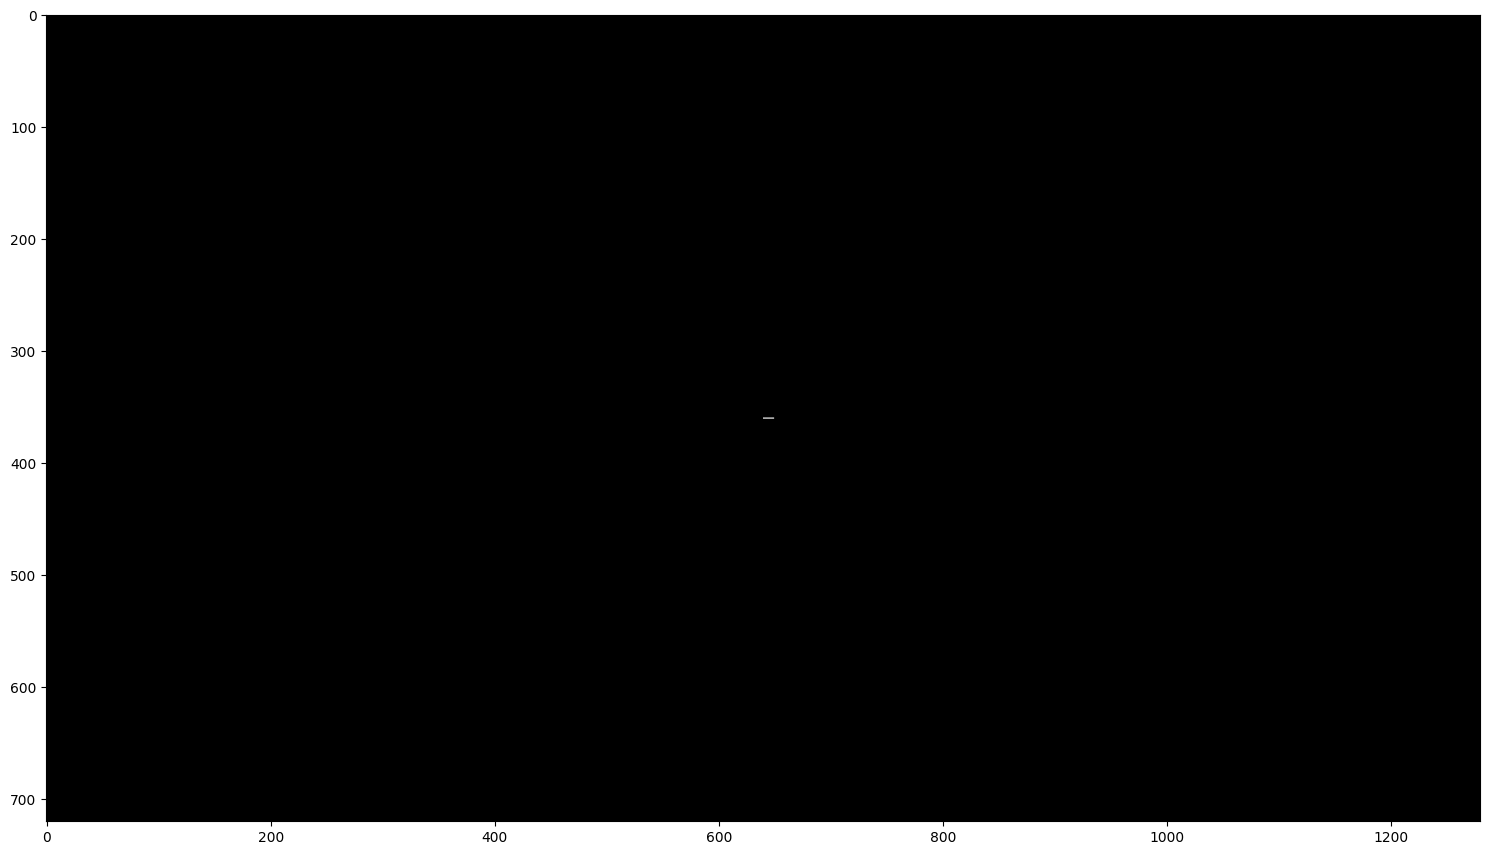

In [88]:
test_img = np.zeros(copact_frames[9].shape)

test_img [360 ,640:650] = 1

plot_image(test_img)

All togheter version 

In [72]:
import pickle

mesh_size = 80
catalog_filter = 6 # Tycho catalog filter for brighness 

name = 'n67_90_tycho6'
if name == None:
    name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open('../data/SOM_parameters/'+name+'/index_'+ name + '.p', 'rb') as infile:
    indices = pickle.load(infile)

In [74]:
#Get the image postion
import time

# ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV

stars_data_df = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
if isinstance(stars_data_df, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data_df[['HIP','RA(ICRS)', 'DE(ICRS)']].values

# Get the clusters that are closest to the center of the image
clusters = clusters_list_filtered
clusters_sort, _= order_by_center_dist(clusters, copact_frames[12].shape)
clusters_sort = [x[0] for x in clusters_sort]

ref_pixel_to_deg = 0.0009601418439716312 #In degres from sun_calibration with FOV=reference_FOV
reference_FOV = 1 #In degrees
recording_FOV = 11.8 #In degrees
num_of_neirbours = 4

# features_vec_1 = []
# features_vec_2 = []
predcited_stars = []
indices_image = []

time_start = time.time()
for main_star in clusters_sort:

    #Order by distance to the main star at the loop
    stars_sorted_by_main, index_sort = order_by_main_dist(main_star, clusters_sort, True)
    indices_image.append(index_sort[0:num_of_neirbours+1])

    # stars_features_1, stars_features_2 = get_star_features(stars_sorted_by_main[0:num_of_neirbours+1],
    #          ref_pixel_to_deg, reference_FOV, recording_FOV)
    
    stars_features_1, stars_features_2 = get_star_features(stars_sorted_by_main[0:num_of_neirbours+1],
                                         ref_pixel_to_deg, reference_FOV, recording_FOV)
    
    # features_vec_1.append(stars_features_1)
    # features_vec_2.append(stars_features_2)

    # Get prediction index
    predicted_star_ids_1 = predict_star_id(stars_features_1, norm_param[0:2], star_dict_1, som1)
    predicted_star_ids_2 = predict_star_id(stars_features_2, norm_param[2:4], star_dict_2, som2)
    
    # Get HIP of index
    hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
    hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]

    # Get the intersection of the two predictions if there is only one star in common
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2 and len(
        list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) > 0:
        star_guess_index = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
        star_guess_id = list(set(hip_ids_predicted_1).intersection(hip_ids_predicted_2))[0]

    else:
        star_guess_index = None
        star_guess_id = None
    predcited_stars.append([hip_ids_predicted_1, hip_ids_predicted_2, star_guess_index, star_guess_id])


#####
indices_neigh_gt  = np.full((len(predcited_stars),num_of_neirbours+1 ), None)
for i, predicted_star in enumerate(predcited_stars):
    if predicted_star[2] is not None:
       indices_neigh_gt[i]  = indices[predicted_star[2]]

indices_neigh_image = np.array([np.array(predcited_stars, dtype=object)[:,2][index] for index in indices_image], dtype=object)

confirmed_stars_ids = check_star_id_by_neight( np.array(indices_neigh_gt, dtype=object),
                                               np.array(indices_neigh_image, dtype=object),
                                               np.array(indices_image, dtype=object),
                                               True)

confirmed_indices = [i for i in range(len(confirmed_stars_ids)) if confirmed_stars_ids[i] is not None]


#####


img_center = np.array(copact_frames[11].shape)/2
distances = []
for confirmed_index in confirmed_indices:
    dist_to_center = np.linalg.norm(img_center - clusters_sort[confirmed_index]) * ref_pixel_to_deg * recording_FOV / reference_FOV
    distances.append(dist_to_center)

print(clusters_sort)
print(confirmed_stars_ids)
print(confirmed_indices)
print(distances)
x_c_solution, y_c_solution = solve_point_c(stars_data[confirmed_stars_ids[confirmed_indices].tolist()][:,1:3], distances)
time_end = time.time()

print('Confirmed stars IDs', confirmed_stars_ids)
print('Center: ', x_c_solution, y_c_solution)
print('Time: ', time_end - time_start, 'average time: ', (time_end - time_start)/len(clusters_sort))
 

[array([375, 554]), array([344, 549]), array([152, 651]), array([309, 398]), array([385, 393]), array([103, 687]), array([304, 907]), array([572, 919]), array([606, 388]), array([211, 988]), array([134, 328]), array([542, 258]), array([ 236, 1097]), array([ 276, 1117]), array([489,  66]), array([   4, 1158]), array([703,  95])]
[20 21 78 56 55 None None None None None 57 None None None None None None]
[0, 1, 2, 3, 4, 10]
[0.9890617010696345, 1.0468152603857874, 2.3598652508396416, 2.8020049259692765, 2.8127269956690246, 4.36479265722049]
Confirmed stars IDs [20 21 78 56 55 None None None None None 57 None None None None None None]
Center:  44.91115444295602 18.47690663753174
Time:  0.0445246696472168 average time:  0.0026190982145421647


In [196]:

cluster_video = ClusterVideo()
# cluster_video.start_video()

cluster_frame = ClusterFrame(copact_frames[0], pixel_range=15, treshold_filter=0.3, mass_treshold=0.2)
cluster_frame.load_som_parameters()
cluster_frame.load_star_catalog()


for frame in copact_frames:
    cluster_frame.update_clusters(frame)
    cluster_frame.compute_ids_predictions()
    cluster_frame.verify_predictions()
    close_callbcak = cluster_video.update_frame(cluster_frame.plot_cluster_cv(stars_ids= cluster_frame.confirmed_stars_ids))
    if close_callbcak:
        cv2.destroyAllWindows()
        break
print('Video finished')
cv2.destroyAllWindows()

<class 'minisom.MiniSom'>
(4566, 3)  Stars loaded
Video finished
